In [2]:
from animalclef.spark import get_spark

spark = get_spark(memory="1g")

25/05/12 16:57:00 WARN Utils: Your hostname, hawksbill-vm resolves to a loopback address: 127.0.1.1; using 192.168.10.12 instead (on interface ens18)
25/05/12 16:57:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/12 16:57:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/12 16:57:00 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [ ]:
from pathlib import Path
from pyspark.sql import functions as F

root = Path("~/scratch/animalclef").expanduser()

# split 0.6 train, 0.8 val/test, 0.5 known/unknown
df = (
    spark.read.json(
        f"{root}/processed/submissions-v1/*/*/best_threshold.json", multiLine=True
    )
    .withColumn("filename", F.input_file_name())
    .withColumn(
        "model", F.udf(lambda p: Path(p).parts[-3], "string")(F.col("filename"))
    )
    .withColumn(
        "epoch", F.udf(lambda p: Path(p).parts[-2], "string")(F.col("filename"))
    )
    .drop("filename")
)
df.show(n=2, vertical=True)

-RECORD 0-------------------------------
 baks            | 0.09520635166496728  
 baus            | 0.43967930242367487  
 crossover_score | 0.6555270492412923   
 mad             | 0.015499573200941086 
 median          | 0.030651036649942398 
 num_neighbors   | 1.0                  
 score           | 0.20459780616212847  
 threshold       | -0.08080808080808088 
 model           | dino-random          
 epoch           | head_epoch=080       
-RECORD 1-------------------------------
 baks            | 0.09598202977093835  
 baus            | 0.4382959445646428   
 crossover_score | 0.6576860852062956   
 mad             | 0.015379564836621284 
 median          | 0.030548837035894394 
 num_neighbors   | 1.0                  
 score           | 0.20510615397809276  
 threshold       | -0.08080808080808088 
 model           | dino-random          
 epoch           | head                 
only showing top 2 rows



In [ ]:
df.select("model", "epoch", "score").orderBy(F.desc("score")).show(n=10)
df.select("model", "epoch", "score").orderBy(F.asc("score")).show(n=10)

+-----------------+--------------+------------------+
|            model|         epoch|             score|
+-----------------+--------------+------------------+
|    dino-semihard|head_epoch=080|0.6275234146971114|
|    dino-semihard|          head|0.6271479839621062|
|    dino-semihard|head_epoch=090|0.6238271200105008|
|    dino-semihard|head_epoch=070|0.6232157075232821|
|    dino-semihard|head_epoch=040|0.6221381969538405|
|dino-semihard-mrl|head_epoch=080|0.6204026403896584|
|dino-semihard-mrl|          head|0.6194342635780161|
|dino-semihard-mrl|head_epoch=070| 0.619403014708913|
|dino-semihard-mrl|head_epoch=060|0.6191441933459889|
|    dino-semihard|head_epoch=060|0.6191053788868561|
+-----------------+--------------+------------------+
only showing top 10 rows

+-----------+--------------+-------------------+
|      model|         epoch|              score|
+-----------+--------------+-------------------+
|dino-random|head_epoch=050|  0.196839902139118|
|dino-random|head_epoc

Text(0.5, 1.0, 'DINO triplet score over epoch')

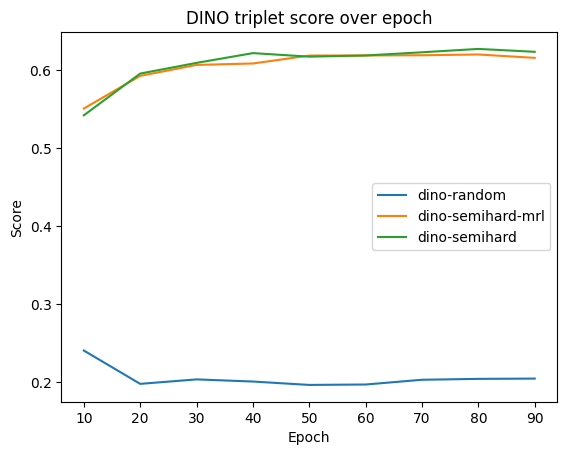

In [ ]:
from matplotlib import pyplot as plt

for row in df.select("model").distinct().collect():
    pdf = (
        df.where(f"model = '{row.model}' and epoch like '%=%'")
        .orderBy("epoch")
        .toPandas()
    )

    plt.plot(
        pdf["epoch"].str.split("=", expand=True)[1].astype(int),
        pdf["score"],
        label=row.model,
    )
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("DINO triplet score over epoch")